In [1]:
# Importing required libraires and packages

import os
from dotenv import load_dotenv
from langgraph.graph import MessagesState,StateGraph,Graph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_chroma import Chroma
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import ToolMessage
load_dotenv()

True

In [2]:
# loading the environment variables
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
# Define the llm using chatgroq
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)

##### Simple Workflow

In [4]:
def call_model(state:MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages":response}


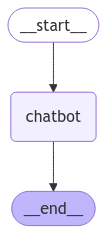

In [5]:
# Create a simple workflow
workflow = StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START,"chatbot")
workflow.add_edge("chatbot",END)
app = workflow.compile()
app

In [6]:
# invoking the response by providing the input
input = {"messages":["Hi My name is Hrishikesh","My surname is Kothawade"]}
response = app.invoke(input)
print(response["messages"])

[HumanMessage(content='Hi My name is Hrishikesh', additional_kwargs={}, response_metadata={}, id='205cd256-c80e-4c2e-9e5d-dd41c601d5e2'), HumanMessage(content='My surname is Kothawade', additional_kwargs={}, response_metadata={}, id='522b3b87-2c2b-4433-a69a-72fb144480a4'), AIMessage(content='Nice to meet you, Hrishikesh Kothawade! How are you doing today? Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 55, 'total_tokens': 91, 'completion_time': 0.171859278, 'prompt_time': 0.012848039, 'queue_time': 0.02045314, 'total_time': 0.184707317}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'stop', 'logprobs': None}, id='run-810dce26-5a7d-4b36-8037-089918b67087-0', usage_metadata={'input_tokens': 55, 'output_tokens': 36, 'total_tokens': 91})]


In [7]:
# Streaming the output
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from the {key} Node")
        print("_________________________")
        print(value)
        print("\n")

Output from the chatbot Node
_________________________
{'messages': AIMessage(content='Nice to meet you, Hrishikesh Kothawade! How are you doing today? Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 55, 'total_tokens': 91, 'completion_time': 0.17131415, 'prompt_time': 0.013072212, 'queue_time': 0.021207155, 'total_time': 0.184386362}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'stop', 'logprobs': None}, id='run-738c27f7-18ae-481c-b6be-131230b6355c-0', usage_metadata={'input_tokens': 55, 'output_tokens': 36, 'total_tokens': 91})}




##### Workflow with custom tool

In [8]:
# Custom tool
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [9]:
search.invoke("What is temperature in India")
search.invoke("What temperature in SF")

"It's 60 degrees and foggy."

In [10]:
# placed custom tool inside the list
tools = [search]

# create the node of tool
tool_node = ToolNode(tools=tools)

# Bind the tools with the LLM
llm_with_tools = llm.bind_tools(tools)


In [11]:
# Agent
def call_model(state:MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages":response}

In [12]:
# Router function to route to specific tool
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [13]:
# desgin the workflow now
workflow = StateGraph(MessagesState)

workflow.add_node("agent",call_model)
workflow.add_node("tools",tool_node)

workflow.add_edge(START,"agent")
workflow.add_conditional_edges("agent",router_function,{"tools":"tools",END:END})

app = workflow.compile()

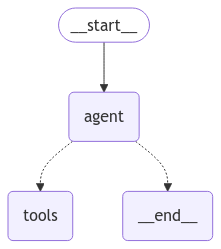

In [14]:
app

In [15]:
response = app.invoke({"messages":["How are you?"]})
response

{'messages': [HumanMessage(content='How are you?', additional_kwargs={}, response_metadata={}, id='40247979-f19b-46cd-bdc5-7945ed10f3ce'),
  AIMessage(content="I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you. Is there something I can help you with?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 212, 'total_tokens': 252, 'completion_time': 0.145454545, 'prompt_time': 0.025401219, 'queue_time': 0.023408012000000002, 'total_time': 0.170855764}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'stop', 'logprobs': None}, id='run-4370b1d6-016b-49a9-bbd2-3a396762f520-0', usage_metadata={'input_tokens': 212, 'output_tokens': 40, 'total_tokens': 252})]}

In [16]:
app.invoke({"messages": ["What temperature in SF"]})

{'messages': [HumanMessage(content='What temperature in SF', additional_kwargs={}, response_metadata={}, id='472752f2-7e92-4671-9241-4af6a53303cc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1hfe', 'function': {'arguments': '{"query": "San Francisco temperature"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 212, 'total_tokens': 227, 'completion_time': 0.054545455, 'prompt_time': 0.023673452, 'queue_time': 0.029606406999999998, 'total_time': 0.078218907}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4196e754db', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2292fc14-14e4-4ace-8b12-ec9917cede1f-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco temperature'}, 'id': 'call_1hfe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 212, 'output_tokens': 15, 'total_tokens': 227}),
  ToolMessage(content="It's 60 degrees and foggy.", nam

##### Looping in the workflow

In [17]:
# Now create the loop from tools to agent
workflow = StateGraph(MessagesState)

workflow.add_node("agent",call_model)
workflow.add_node("tools",tool_node)

workflow.add_edge(START,"agent")
workflow.add_conditional_edges("agent",router_function,{"tools":"tools",END:END})
loop_app = workflow.compile()

In [18]:
workflow.add_edge("tools","agent")
loop_app =workflow.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


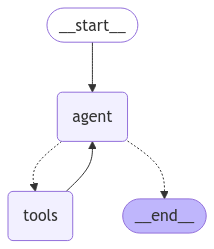

In [19]:
loop_app

In [20]:
# Streaming the output

for output in loop_app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_byey', 'function': {'arguments': '{"query": "San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 214, 'total_tokens': 229, 'completion_time': 0.054545455, 'prompt_time': 0.023893102, 'queue_time': 0.026796918000000003, 'total_time': 0.078438557}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4196e754db', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-77eb639c-de67-4881-b73b-6f75467b6774-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': 'call_byey', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 15, 'total_tokens': 229})}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='0748c157-0504-47ad-918e-aed29170a073', tool_call

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

##### Memory in the workflow

In [4]:
# Initialize the in-memory saver class to store the memory
# For production-level application, you should used postgres or any relevant database
memory = MemorySaver()

# Initialize the LLM model
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)

# Define Tools
# Tool1 : Travily Search
@tool
def get_latest_news(query:str):
    """
    Call this tool to answer news reataed questions.
    Example : Give me the latest news related to Los Angelis (LA)
    """
    print("Travily search calling....")
    travily_search = TavilySearchResults()
    response = travily_search.invoke(query)
    print("Response generated by travily : ",response)
    return response

@tool
def call_model(query:str):
    """Call this tool for any questions"""
    print("LLM model calling.....")
    response = llm.invoke(query)
    print("Response generated by LLM",response)
    return response

# Placed tools in list
tools = [get_latest_news,call_model]

# Create the tool node
tool_node = ToolNode(tools)

# Bind the tools with the LLM
llm_with_tools = llm.bind_tools(tools=tools)

# Agent : Build the Agent which will decide which tool to use
def invoke_model(state:MessagesState):
    print("calling Agent")
    messages = state["messages"]
    # print("messages from the invoke model : ",messages)
    response = llm_with_tools.invoke(messages)
    print("Response generated by llm_with_tools : ",response)
    return {"messages":response}

# Router : which will route the query
def router(state: MessagesState):
    print("Router deciding the flow")
    messages = state['messages']
    last_message = messages[-1]

    if last_message.tool_calls:
        print("Router decided to call tools")
        return "tools"
    
    print("Router decided to END")
    return END

# Define new workflow / graph
memory_workflow = StateGraph(MessagesState)

memory_workflow.add_node("agent",invoke_model)
memory_workflow.add_node("tools",tool_node)
memory_workflow.add_edge(START,"agent")

memory_workflow.add_edge("tools","agent")
memory_workflow.add_conditional_edges("agent",router,{"tools":"tools",END:END})

memory_app = memory_workflow.compile()

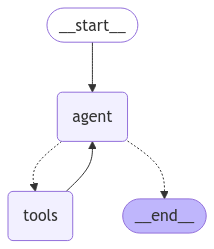

In [5]:
memory_app

In [9]:
config = {"configurable":{"thread_id":"1"}}
memory_app.invoke({"messages":["Hi My name is Hrishikesh Kothawade and I am working as a Software engineer in capgemini"]},config)

calling Agent
Response generated by llm_with_tools :  content='' additional_kwargs={'tool_calls': [{'id': 'call_z8dq', 'function': {'arguments': '{"query": "Nice to meet you, Hrishikesh Kothawade. What can I help you with today?"}', 'name': 'call_model'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 328, 'total_tokens': 363, 'completion_time': 0.127272727, 'prompt_time': 0.018332875, 'queue_time': 0.27283319800000005, 'total_time': 0.145605602}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ca0059abb', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-a017ee3f-a845-4f15-ae9e-86b42b693a7c-0' tool_calls=[{'name': 'call_model', 'args': {'query': 'Nice to meet you, Hrishikesh Kothawade. What can I help you with today?'}, 'id': 'call_z8dq', 'type': 'tool_call'}] usage_metadata={'input_tokens': 328, 'output_tokens': 35, 'total_tokens': 363}
Router deciding the flow
Router decided to call tools
LLM model callin

KeyboardInterrupt: 

In [10]:
# Associate the memory with the workflow
memory_app = memory_workflow.compile(checkpointer=memory)

# config
config = {"configurable":{"thread_id":"1"}}

events = memory_app.stream({"messages":["What is my name ?"]},config,stream_mode="values")

In [ ]:
memory_app.invoke({"messages":["My name is Rohit Sharma, I am a GenAI engineer?"]},config)

In [10]:
memory_app.invoke({"messages":["what did I ask you in previous response?"]},config)

calling Agent
Response generated by llm_with_tools :  content='' additional_kwargs={'tool_calls': [{'id': 'call_vvz3', 'function': {'arguments': '{"query": "Rohit Sharma GenAI engineer previous response"}', 'name': 'call_model'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1444, 'total_tokens': 1467, 'completion_time': 0.083636364, 'prompt_time': 0.199142954, 'queue_time': 0.5445715299999999, 'total_time': 0.282779318}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-c66ae7fd-dcd2-4b22-99e2-dd241930c896-0' tool_calls=[{'name': 'call_model', 'args': {'query': 'Rohit Sharma GenAI engineer previous response'}, 'id': 'call_vvz3', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1444, 'output_tokens': 23, 'total_tokens': 1467}
Router deciding the flow
Router decided to call tools
LLM model calling.....
Response generated by LLM content="This co

{'messages': [HumanMessage(content='My name is Rohit Sharma, I am a GenAI engineer?', additional_kwargs={}, response_metadata={}, id='05238a82-0176-4d9d-afd6-a555671798b5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v06v', 'function': {'arguments': '{"query": "Rohit Sharma GenAI engineer"}', 'name': 'call_model'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 318, 'total_tokens': 339, 'completion_time': 0.076363636, 'prompt_time': 0.038757001, 'queue_time': 0.048664867, 'total_time': 0.115120637}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ccae5221-0749-4475-b9f8-0b8c9f6c4e55-0', tool_calls=[{'name': 'call_model', 'args': {'query': 'Rohit Sharma GenAI engineer'}, 'id': 'call_v06v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 318, 'output_tokens': 21, 'total_tokens': 339}),
  ToolMessage(content='cont

In [ ]:
# memory.get(config)

##### Lets tryout this code also : from langGraph website

In [15]:
from typing import Annotated

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable":{"thread_id":"hrishi1"}}

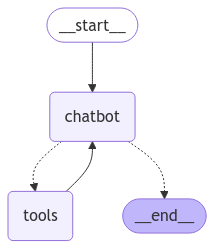

In [16]:
graph

In [21]:
user_input = input("Ask the question to bot :")
response = graph.invoke({"messages":[{"role":"user","content":user_input}]},config=config)
print(response)

{'messages': [HumanMessage(content='Who is Rohit Sharma ?', additional_kwargs={}, response_metadata={}, id='8a0eb78b-544c-44b4-af05-1c14e7fb868c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_29ry', 'function': {'arguments': '{"query": "Rohit Sharma biography"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 284, 'total_tokens': 306, 'completion_time': 0.08, 'prompt_time': 0.035592481, 'queue_time': 0.059485276, 'total_time': 0.115592481}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a049bb98-8353-435b-a9c9-e278fe377f4a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Rohit Sharma biography'}, 'id': 'call_29ry', 'type': 'tool_call'}], usage_metadata={'input_tokens': 284, 'output_tokens': 22, 'total_tokens': 306}), ToolMessage(content='[{"url": "https://w

In [29]:
response['messages'][-1].content

'Rohit Sharma is an Indian international cricketer and the current captain of the Indian cricket team in the Test and One-Day International (ODI) formats. He was also the captain of India’s Twenty20 International team until he announced his retirement on June 29, 2024, after leading the Indian side to its T20I World Cup victory.'

In [30]:
user_input = input("Ask the question to bot :")
response = graph.invoke({"messages":[user_input]},config=config)
print(response['messages'][-1].content)

You asked "Who is Rohit Sharma ?"
